In [10]:
import json
import logging
import networkx as nx
import matplotlib.pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.INFO) # set to logging.INFO to follow internal logic or logging.WARNING for silence

## node

Nodes represent segments of sequence.
Nodes have a `node_id`, a `first` position, and a `last` position using BED-style coordinates (although at the moment, the positions aren't used).
The first or last positions may be specified as `*` to denote that they are the first or last node in the path.
Nodes are always represented as top strand reference orientation.  `node_id` are assigned as consecutive letters in top strand reference order.

```
N node_id first last
```

In [11]:
# a complementary node is the same node on the opposite strand
def complementary_node_id(node_id):
  """Use prime to denote the opposite strand"""
  return node_id if node_id.endswith("'") else f"{node_id}'"

def minus_strand_node(node):
  """Return the node on the minus strand"""
  return {
    'node_id': complementary_node_id(node['node_id']),
    'first': node['last'],
    'last': node['first']
  }

def load_nodes_data(filename):
  logging.info(f"Loading nodes data from {filename}")
  with open(filename, 'r') as f:
    return json.load(f)
  
def add_nodes(G, nodes_data):
  for node in nodes_data + [minus_strand_node(_) for _ in nodes_data]:
    logging.info(f"Adding node {node['node_id']} to the graph")
    G.add_node(node['node_id'], first=node['first'], last=node['last'])

## edge

Edges are connections between nodes.

```
E node_id1 node_id2 explicit read_support
```

- explicit/implicit (bool) is a flag that indicates whether the edge is explicit (true) or implicit (false)
  - explicit edges pass from node to node with a discontinuity in position, i.e., the right end of node_id1 is not the same as the left end of node_id2
  - implicit edges pass from node to node without a discontinuity in position; i.e. the right end of node_id1 is directly connected to the left end of node_id2 in the same orientation
  - edges representing deletions or insertions always connect opposite ends in the same orientation
  - edges representing inversions always connect ends in opposite orientations
- read_support is the number (int) of reads supporting the edge; not using this for now, but we could eventually use it to allow an explicit edge to be traversed more than once
  - for implicit edges, read_support is the read depth at the position of the edge
  - for explicit edges, read_support is the number of reads that span the edge
- edges are bidirectional, i.e., an edge exiting node1 on the right and entering node2 on the left in the same orientation is equivalent to an edge exiting node2 on the right and entering node1 on the left in the same orientation; we implement this by explicity adding the complementary edge to the complementary node
- paths travel from "left" to "right"

In [12]:
def load_edges_data(filename):
  logging.info(f"Loading edges data from {filename}")
  with open(filename, 'r') as f:
    return json.load(f)

def generate_implicit_edge_data(nodes_data):
  return [
    {
      'node_id1': first['node_id'],
      'node_id2': second['node_id'],
      'explicit': False,
      'read_support': 5
    }
    for first, second in zip(nodes_data, nodes_data[1:])
  ]

def add_edges(G, edges_data):
  for edge in edges_data:
  # we're going to add the edge twice, once for each direction
  # since it's still just a single edge, we'll assign a unique id
  # use the unique_id later to require that an explicit edge is only traversed once
    unique_edge_id = f"{edge['node_id1']}_{edge['node_id2']}"
    logging.info(f"Adding {'explicit' if edge['explicit'] else 'implicit'} edge ({edge['node_id1']}, {edge['node_id2']}) with unique id {unique_edge_id}")
    G.add_edge(
      edge['node_id1'],
      edge['node_id2'],
      explicit=edge['explicit'],
      read_support=edge['read_support'],
      unique_id=unique_edge_id
    )
    logging.info(f"Adding {'explicit' if edge['explicit'] else 'implicit'} edge ({complementary_node_id(edge['node_id2'])}, {complementary_node_id(edge['node_id1'])}) with unique id {unique_edge_id}")
    G.add_edge(
      complementary_node_id(edge['node_id2']),
      complementary_node_id(edge['node_id1']),
      explicit=edge['explicit'],
      read_support=edge['read_support'],
      unique_id=unique_edge_id
    )


## paths

Paths are sequences of nodes.  We're interested in paths starting at the first node and ending at the last node.

Reference paths involving only implicit edges are considered trivial.

Paths that do not use all explicit edges once and only once are considered invalid.

In [13]:
def plot_graph(G):
    nx.draw_networkx(
        G,
        pos=nx.planar_layout(G),
        with_labels=True,
    )
    plt.show()

def print_cycles(G):
    print("All cycles:")
    for cycle in nx.simple_cycles(G):
        print(' -> '.join(cycle))

def print_simple_paths(G, source, target):
    print("All simple paths:")
    for path in sorted(nx.all_simple_paths(G, source, target), key=lambda path: len(path)):
        print(' -> '.join(path))

def filter_paths(G, source, target):
    """Check each path to ensure that each explicit edge is used once and only once"""
    filtered_paths = []
    for path in nx.all_simple_paths(G, source, target):
        logging.info(f"Checking path {path}")
        explicit_edges = list(set([d['unique_id'] for _, _, d in G.edges(data=True) if d['explicit']]))
        logging.info(f"Explicit edges: {explicit_edges}")
        # for each edge in path
        for i in range(len(path)-1):
            # if the edge is explicit and not still available, remove the path
            if G.edges[path[i], path[i+1]]['explicit']:
                logging.info(f"({path[i]}, {path[i+1]}) is an explicit edge with unique_id {G.edges[path[i], path[i+1]]['unique_id']}")
                if G.edges[path[i], path[i+1]]['unique_id'] not in explicit_edges:
                    logging.info(f"Removing path {path} because explicit edge {G.edges[path[i], path[i+1]]['unique_id']} has already been traversed")
                    break
                logging.info(f"Removing edge {G.edges[path[i], path[i+1]]['unique_id']} from available edges")
                explicit_edges.remove(G.edges[path[i], path[i+1]]['unique_id'])
        logging.info(f"Explicit edges left: {explicit_edges}")
        if not explicit_edges:
            logging.info(f"Path {path} is valid and nontrivial")
            filtered_paths.append(path)
        else:
            logging.info(f"Path {path} is invalid or trivial")
    return filtered_paths


In [14]:
def solve_graph(nodes_data_file_path, edges_data_file_path):
  # create graph
  G = nx.DiGraph()
  #G = nx.MultiDiGraph()

  # load node data
  nodes_data = load_nodes_data(nodes_data_file_path)
  add_nodes(G, nodes_data)

  first_node = nodes_data[0]['node_id']
  last_node = nodes_data[-1]['node_id']

  # load edge data
  explicit_edges_data = load_edges_data(edges_data_file_path)
  implicit_edges_data = generate_implicit_edge_data(nodes_data)
  add_edges(G, explicit_edges_data + implicit_edges_data)

  # plot graph
  plot_graph(G)

  # print cycles
  print_cycles(G)

  # print simple paths
  print_simple_paths(G, first_node, last_node)

  # print filtered paths that use all explicit edges once and only once
  print("Valid, nontrivial paths:")
  for path in sorted(filter_paths(G, first_node, last_node), key=lambda path: len(path)):
    print(' -> '.join(path))

INFO:root:Loading nodes data from nodes/simple_nodes.json
INFO:root:Adding node A to the graph
INFO:root:Adding node B to the graph
INFO:root:Adding node C to the graph
INFO:root:Adding node D to the graph
INFO:root:Adding node A' to the graph
INFO:root:Adding node B' to the graph
INFO:root:Adding node C' to the graph
INFO:root:Adding node D' to the graph
INFO:root:Loading edges data from edges/simple_deletion.json
INFO:root:Adding explicit edge (B, D) with unique id B_D
INFO:root:Adding explicit edge (D', B') with unique id B_D
INFO:root:Adding implicit edge (A, B) with unique id A_B
INFO:root:Adding implicit edge (B', A') with unique id A_B
INFO:root:Adding implicit edge (B, C) with unique id B_C
INFO:root:Adding implicit edge (C', B') with unique id B_C
INFO:root:Adding implicit edge (C, D) with unique id C_D
INFO:root:Adding implicit edge (D', C') with unique id C_D


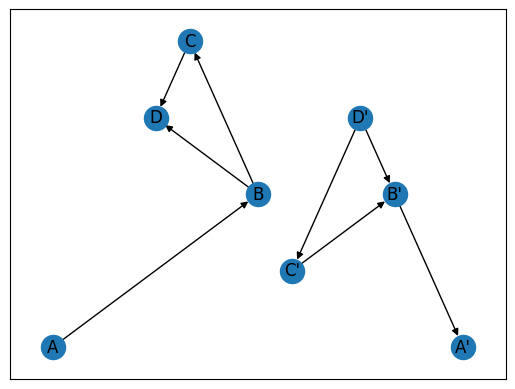

INFO:root:Checking path ['A', 'B', 'D']
INFO:root:Explicit edges: ['B_D']
INFO:root:(B, D) is an explicit edge with unique_id B_D
INFO:root:Removing edge B_D from available edges
INFO:root:Explicit edges left: []
INFO:root:Path ['A', 'B', 'D'] is valid and nontrivial
INFO:root:Checking path ['A', 'B', 'C', 'D']
INFO:root:Explicit edges: ['B_D']
INFO:root:Explicit edges left: ['B_D']
INFO:root:Path ['A', 'B', 'C', 'D'] is invalid or trivial


All cycles:
All simple paths:
A -> B -> D
A -> B -> C -> D
Valid, nontrivial paths:
A -> B -> D


In [15]:
solve_graph('nodes/simple_nodes.json', 'edges/simple_deletion.json')
# for simple deletions, the two graphs should be disconnected because no explicit edges connect them
# we want the answer ABD

INFO:root:Loading nodes data from nodes/simple_nodes.json
INFO:root:Adding node A to the graph
INFO:root:Adding node B to the graph
INFO:root:Adding node C to the graph
INFO:root:Adding node D to the graph
INFO:root:Adding node A' to the graph
INFO:root:Adding node B' to the graph
INFO:root:Adding node C' to the graph
INFO:root:Adding node D' to the graph
INFO:root:Loading edges data from edges/simple_duplication.json
INFO:root:Adding explicit edge (C, B) with unique id C_B
INFO:root:Adding explicit edge (B', C') with unique id C_B
INFO:root:Adding implicit edge (A, B) with unique id A_B
INFO:root:Adding implicit edge (B', A') with unique id A_B
INFO:root:Adding implicit edge (B, C) with unique id B_C
INFO:root:Adding implicit edge (C', B') with unique id B_C
INFO:root:Adding implicit edge (C, D) with unique id C_D
INFO:root:Adding implicit edge (D', C') with unique id C_D


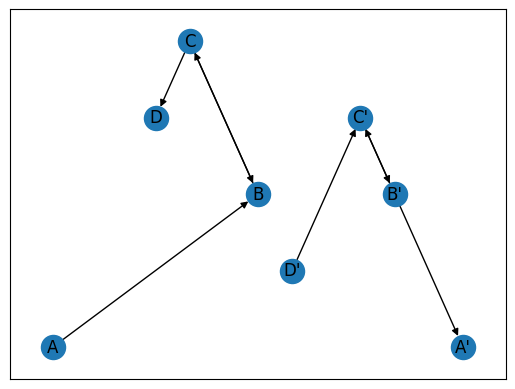

INFO:root:Checking path ['A', 'B', 'C', 'D']
INFO:root:Explicit edges: ['C_B']
INFO:root:Explicit edges left: ['C_B']
INFO:root:Path ['A', 'B', 'C', 'D'] is invalid or trivial


All cycles:
B' -> C'
C -> B
All simple paths:
A -> B -> C -> D
Valid, nontrivial paths:


In [16]:
solve_graph('nodes/simple_nodes.json', 'edges/simple_duplication.json')
# for simple duplications, the two graphs should be disconnected because no explicit edges connect them
# there are bidirectional edges along the duplicated edge, leading to a cycle
# we actually want to allow explicit edges (by their unique_id) to be traversed once and only once
# which could prevent recursion in the cycles
# we want the answer ABCBCD

INFO:root:Loading nodes data from nodes/simple_nodes.json
INFO:root:Adding node A to the graph
INFO:root:Adding node B to the graph
INFO:root:Adding node C to the graph
INFO:root:Adding node D to the graph
INFO:root:Adding node A' to the graph
INFO:root:Adding node B' to the graph
INFO:root:Adding node C' to the graph
INFO:root:Adding node D' to the graph
INFO:root:Loading edges data from edges/simple_inversion.json
INFO:root:Adding explicit edge (C, B') with unique id C_B'
INFO:root:Adding explicit edge (B', C') with unique id C_B'
INFO:root:Adding explicit edge (B', D) with unique id B'_D
INFO:root:Adding explicit edge (D', B') with unique id B'_D
INFO:root:Adding implicit edge (A, B) with unique id A_B
INFO:root:Adding implicit edge (B', A') with unique id A_B
INFO:root:Adding implicit edge (B, C) with unique id B_C
INFO:root:Adding implicit edge (C', B') with unique id B_C
INFO:root:Adding implicit edge (C, D) with unique id C_D
INFO:root:Adding implicit edge (D', C') with unique i

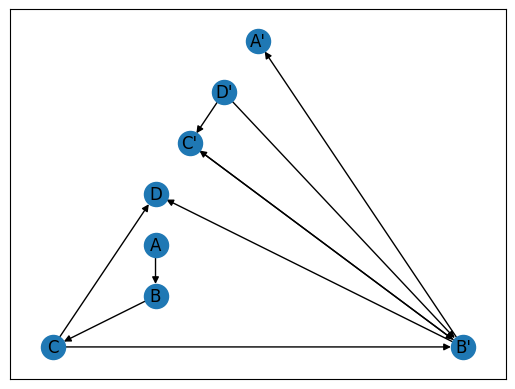

INFO:root:Checking path ['A', 'B', 'C', "B'", 'D']
INFO:root:Explicit edges: ["C_B'", "B'_D"]
INFO:root:(C, B') is an explicit edge with unique_id C_B'
INFO:root:Removing edge C_B' from available edges
INFO:root:(B', D) is an explicit edge with unique_id B'_D
INFO:root:Removing edge B'_D from available edges
INFO:root:Explicit edges left: []
INFO:root:Path ['A', 'B', 'C', "B'", 'D'] is valid and nontrivial
INFO:root:Checking path ['A', 'B', 'C', 'D']
INFO:root:Explicit edges: ["C_B'", "B'_D"]
INFO:root:Explicit edges left: ["C_B'", "B'_D"]
INFO:root:Path ['A', 'B', 'C', 'D'] is invalid or trivial


All cycles:
B' -> C'
All simple paths:
A -> B -> C -> D
A -> B -> C -> B' -> D
Valid, nontrivial paths:
A -> B -> C -> B' -> D


In [17]:
solve_graph('nodes/simple_nodes.json', 'edges/simple_inversion.json')
# inversions connect the two graphs
# we want the answer ABCB'D

INFO:root:Loading nodes data from nodes/complex_nodes.json
INFO:root:Adding node A to the graph
INFO:root:Adding node B to the graph
INFO:root:Adding node C to the graph
INFO:root:Adding node D to the graph
INFO:root:Adding node E to the graph
INFO:root:Adding node F to the graph
INFO:root:Adding node G to the graph
INFO:root:Adding node H to the graph
INFO:root:Adding node I to the graph
INFO:root:Adding node A' to the graph
INFO:root:Adding node B' to the graph
INFO:root:Adding node C' to the graph
INFO:root:Adding node D' to the graph
INFO:root:Adding node E' to the graph
INFO:root:Adding node F' to the graph
INFO:root:Adding node G' to the graph
INFO:root:Adding node H' to the graph
INFO:root:Adding node I' to the graph
INFO:root:Loading edges data from edges/complex.json
INFO:root:Adding explicit edge (A, D') with unique id A_D'
INFO:root:Adding explicit edge (D', A') with unique id A_D'
INFO:root:Adding explicit edge (D', B) with unique id D'_B
INFO:root:Adding explicit edge (B',

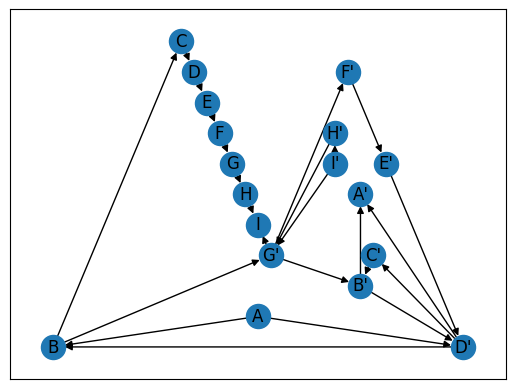

INFO:root:Checking path ['A', "D'", 'B', "G'", 'I']
INFO:root:Explicit edges: ["A_D'", "B_G'", "G'_I", "D'_B"]
INFO:root:(A, D') is an explicit edge with unique_id A_D'
INFO:root:Removing edge A_D' from available edges
INFO:root:(D', B) is an explicit edge with unique_id D'_B
INFO:root:Removing edge D'_B from available edges
INFO:root:(B, G') is an explicit edge with unique_id B_G'
INFO:root:Removing edge B_G' from available edges
INFO:root:(G', I) is an explicit edge with unique_id G'_I
INFO:root:Removing edge G'_I from available edges
INFO:root:Explicit edges left: []
INFO:root:Path ['A', "D'", 'B', "G'", 'I'] is valid and nontrivial
INFO:root:Checking path ['A', "D'", 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
INFO:root:Explicit edges: ["A_D'", "B_G'", "G'_I", "D'_B"]
INFO:root:(A, D') is an explicit edge with unique_id A_D'
INFO:root:Removing edge A_D' from available edges
INFO:root:(D', B) is an explicit edge with unique_id D'_B
INFO:root:Removing edge D'_B from available edges
INFO:

All cycles:
D' -> B -> G' -> B'
D' -> B -> G' -> F' -> E'
D' -> C' -> B'
All simple paths:
A -> B -> G' -> I
A -> D' -> B -> G' -> I
A -> B -> C -> D -> E -> F -> G -> H -> I
A -> D' -> B -> C -> D -> E -> F -> G -> H -> I
Valid, nontrivial paths:
A -> D' -> B -> G' -> I


In [18]:
solve_graph('nodes/complex_nodes.json', 'edges/complex.json')
# we want the answer AD'BG'I